In [ ]:
!curl https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv -o time_series_covid19_confirmed_global.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  619k  100  619k    0     0  17.2M      0 --:--:-- --:--:-- --:--:-- 17.2M


In [ ]:
import pandas as pd
from pandas import DataFrame as df
WINDOW = 7
data = pd.read_csv('/content/time_series_covid19_confirmed_global.csv', index_col='Country/Region')
data = df(data.loc['Japan'])
data = data.drop(['Province/State', 'Lat', 'Long'])
new_data = df()
new_data['date'] = data.T.columns
new_data['confirmed'] = data['Japan'].values
print(new_data)
# add_data = df()
# add_data['date'] = ['5/19/21']
# add_data['confirmed'] = [2533]
# new_data = new_data.append(add_data, ignore_index=True)
print(new_data)
for i in range(new_data.shape[0]-1):
  new_data['confirmed'][i] = new_data['confirmed'][i+1] - new_data['confirmed'][i]
print(new_data)
new_data = new_data.drop(index=new_data.shape[0]-1)
new_data.confirmed

        date confirmed
0    1/22/20         2
1    1/23/20         2
2    1/24/20         2
3    1/25/20         2
4    1/26/20         4
..       ...       ...
481  5/17/21    688873
482  5/18/21    694077
483  5/19/21    699931
484  5/20/21    705641
485  5/21/21    710895

[486 rows x 2 columns]
        date confirmed
0    1/22/20         2
1    1/23/20         2
2    1/24/20         2
3    1/25/20         2
4    1/26/20         4
..       ...       ...
481  5/17/21    688873
482  5/18/21    694077
483  5/19/21    699931
484  5/20/21    705641
485  5/21/21    710895

[486 rows x 2 columns]
        date confirmed
0    1/22/20         0
1    1/23/20         0
2    1/24/20         0
3    1/25/20         2
4    1/26/20         0
..       ...       ...
481  5/17/21      5204
482  5/18/21      5854
483  5/19/21      5710
484  5/20/21      5254
485  5/21/21    710895

[486 rows x 2 columns]


0         0
1         0
2         0
3         2
4         0
       ... 
480    3738
481    5204
482    5854
483    5710
484    5254
Name: confirmed, Length: 485, dtype: object

In [ ]:
import tensorflow as tf
import numpy as np
import pickle
import array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras import optimizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(np.reshape(np.array(new_data.confirmed, dtype=np.float16), (-1, 1)))
print(training_set_scaled.shape)

(485, 1)


In [ ]:
X_train = []
y_train = []
for i in range(WINDOW, 384):
    X_train.append(training_set_scaled[i-WINDOW:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train)
print(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

[[0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 3.791e-04 0.000e+00]
 [0.000e+00 0.000e+00 2.527e-04 ... 3.791e-04 0.000e+00 5.054e-04]
 [0.000e+00 2.527e-04 0.000e+00 ... 0.000e+00 5.054e-04 5.054e-04]
 ...
 [3.372e-01 2.262e-01 2.922e-01 ... 3.276e-01 2.991e-01 2.869e-01]
 [2.262e-01 2.922e-01 3.325e-01 ... 2.991e-01 2.869e-01 2.069e-01]
 [2.922e-01 3.325e-01 3.276e-01 ... 2.869e-01 2.069e-01 1.550e-01]]
[5.0545e-04 5.0545e-04 6.3181e-04 0.0000e+00 0.0000e+00 2.5272e-04
 1.2636e-04 0.0000e+00 0.0000e+00 1.2636e-04 0.0000e+00 2.5272e-04
 1.2636e-04 1.2636e-04 6.3181e-04 1.2636e-03 1.3905e-03 7.5817e-04
 8.8453e-04 1.5163e-03 7.5817e-04 1.2636e-03 2.1477e-03 3.1586e-03
 1.5163e-03 1.3905e-03 1.6422e-03 2.4014e-03 3.2845e-03 2.2736e-03
 1.1368e-03 1.7691e-03 2.4014e-03 2.5272e-03 4.4212e-03 4.0436e-03
 6.9504e-03 5.8136e-03 4.1695e-03 3.5381e-03 7.3280e-03 6.9504e-03
 7.0763e-03 4.6768e-03 7.8354e-03 3.9177e-03 2.1477e-03 6.3171e-03
 4.4212e-03 5.0545e-03 6.8245e-03 4.6768e-03 5.6877e-03 

In [ ]:
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 1024, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 512, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 256, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 32))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
12/12 [==============================] - 5s 17ms/step - loss: 0.0311
Epoch 2/100
12/12 [==============================] - 0s 15ms/step - loss: 0.0063
Epoch 3/100
12/12 [==============================] - 0s 13ms/step - loss: 0.0091
Epoch 4/100
12/12 [==============================] - 0s 13ms/step - loss: 0.0081
Epoch 5/100
12/12 [==============================] - 0s 13ms/step - loss: 0.0059
Epoch 6/100
12/12 [==============================] - 0s 14ms/step - loss: 0.0039
Epoch 7/100
12/12 [==============================] - 0s 13ms/step - loss: 0.0073
Epoch 8/100
12/12 [==============================] - 0s 13ms/step - loss: 0.0077
Epoch 9/100
12/12 [==============================] - 0s 12ms/step - loss: 0.0057
Epoch 10/100
12/12 [==============================] - 0s 12ms/step - loss: 0.0036
Epoch 11/100
12/12 [==============================] - 0s 12ms/step - loss: 0.0075
Epoch 12/100
12/12 [==============================] - 0s 13ms/step - loss: 0.0049
Epoch 13/100
12/12 [=====

In [ ]:
data = pd.read_csv('/content/time_series_covid19_confirmed_global.csv', index_col='Country/Region')
data = df(data.loc['Taiwan*'])
data = data.drop(['Province/State', 'Lat', 'Long'])
new_data = df()
new_data['date'] = data.T.columns
new_data['confirmed'] = data['Taiwan*'].values
print(new_data)
print(new_data)
for i in range(new_data.shape[0]-1):
  new_data['confirmed'][i] = new_data['confirmed'][i+1] - new_data['confirmed'][i]
print(new_data)
new_data = new_data.drop(index=new_data.shape[0]-1)
new_data.confirmed

real_ = df(new_data).iloc[:, 1:2].values
print(new_data)
dataset_total = df(real_)
inputs = dataset_total.values
inputs = inputs.reshape(-1,1)
sc = MinMaxScaler(feature_range = (0, 1))
print(inputs)
inputs = sc.fit_transform(inputs)
X_test = []
for i in range(WINDOW, inputs.shape[0]):
  X_test.append(inputs[i-WINDOW:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_ = model.predict(X_test)
predicted_ = sc.inverse_transform(predicted_)
print(predicted_)

        date confirmed
0    1/22/20         1
1    1/23/20         1
2    1/24/20         3
3    1/25/20         3
4    1/26/20         4
..       ...       ...
481  5/17/21      2017
482  5/18/21      2260
483  5/19/21      2533
484  5/20/21      2825
485  5/21/21      3139

[486 rows x 2 columns]
        date confirmed
0    1/22/20         1
1    1/23/20         1
2    1/24/20         3
3    1/25/20         3
4    1/26/20         4
..       ...       ...
481  5/17/21      2017
482  5/18/21      2260
483  5/19/21      2533
484  5/20/21      2825
485  5/21/21      3139

[486 rows x 2 columns]
        date confirmed
0    1/22/20         0
1    1/23/20         2
2    1/24/20         0
3    1/25/20         1
4    1/26/20         1
..       ...       ...
481  5/17/21       243
482  5/18/21       273
483  5/19/21       292
484  5/20/21       314
485  5/21/21      3139

[486 rows x 2 columns]
        date confirmed
0    1/22/20         0
1    1/23/20         2
2    1/24/20         0
3    1/2

In [ ]:
predicted_.shape

(478, 1)

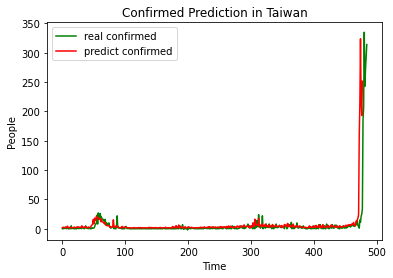

In [ ]:
import matplotlib.pyplot as plt
plt.plot(real_, color = 'green', label = 'real confirmed')
plt.plot(predicted_, color = 'red', label = 'predict confirmed')
plt.title('Confirmed Prediction in Taiwan')
plt.xlabel('Time')
plt.ylabel('People')
plt.legend()
plt.show()